## First Simulation Study

### Load Libraries

In [1]:
import numpy as np
import scipy.stats as stats
##Library neural nets
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
# Library for Gaussian process
import GPy
##Library for visualization
import matplotlib as mpl
mpl.style.use("seaborn")
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab 

/Users/liy0h/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# split into input (X) and output (Y) variables
N = 1000 ##Sample Size
P = 1 ##Covariates
M = 20 ##replicates
X = np.array([np.ones(N)]).T ##Design matrix
kernel = GPy.kern.Exponential(1,1,0.1) ##Covariance Function
noise_var = 0.01 ##Nugget variance
# 1000 points evenly spaced over [0,1]
s = np.linspace(0,1,N).reshape(-1,1)
mu = np.ones(N).reshape(-1,1) # vector of the means
nugget = np.eye(N) * noise_var ##Nugget matrix
cov_mat = kernel.K(s) + nugget ##Covariance matrix
# Generate M sample path with mean mu and covariance C
np.random.seed(1)
y = np.random.multivariate_normal(mu[:,0],cov_mat,M).T

In [3]:
print(y.shape) ##check the dimension of y

(1000, 20)


### Visualize the Observation

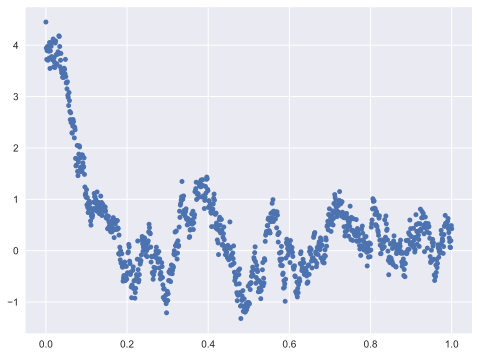

In [4]:
plt.plot(s,y[:,0],".",mew=1.5)
plt.show()
#plt.savefig("trueGP.pdf")

### Create a neural network with three hidden layers

In [5]:
def create_mlp(feature_dim):
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim = feature_dim,  kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model

### Generate basis functions

In [6]:
num_basis = [10,19,37,73]
knots = [np.linspace(0,1,i) for i in num_basis]
##Wendland kernel
K = 0 ## basis size
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/num_basis[res]*2.5
    for i in range(num_basis[res]):
        d = np.absolute(s-knots[res][i])/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

Check the dimension of $s$, $X$ and $y$

In [7]:
print(s.shape)
print(X.shape)
print(y.shape)
print(phi.shape)

(1000, 1)
(1000, 1)
(1000, 20)
(1000, 139)


### Split the data

In [8]:
from sklearn.model_selection import train_test_split
indices = np.arange(N)
## Split the training and testing sets
s_train, s_test, X_train, X_test, phi_train, phi_test\
    , y_train, y_test, idx_train, idx_test \
    = train_test_split(s, X, phi, y, indices, test_size=0.2)
N_train = s_train.shape[0]
N_test = s_test.shape[0]

In [9]:
print([N_train,N_test]) 

[800, 200]


** Only with X=1 **

In [10]:
model_1 = create_mlp(feature_dim = P)
 
# train the model
print("[INFO] training model 1...")
model_1.fit(X_train, y_train[:,0], epochs = 100, batch_size = 32, verbose = 0)

Instructions for updating:
Colocations handled automatically by placer.
[INFO] training model 1...
Instructions for updating:
Use tf.cast instead.


** With s and X **

In [11]:
model_2 = create_mlp(feature_dim = P + 1)
Xs_train = np.hstack((X_train,s_train)) 
# train the model
print("[INFO] training model 2...")
model_2.fit(Xs_train, y_train[:,0], epochs = 100, batch_size = 32, verbose = 0)

[INFO] training model 2...


** With RBF and X **

In [12]:
model_3 = create_mlp(feature_dim = P + K)
XRBF_train = np.hstack((X_train,phi_train)) 
# train the model
print("[INFO] training model 3...")
train_history = model_3.fit(XRBF_train, y_train[:,0], epochs = 100, batch_size = 32, verbose = 0)

[INFO] training model 3...


In [13]:
Xs = np.hstack((X,s))
XRBF = np.hstack((X,phi))
y0_test_1 = model_1.predict(X)
y0_test_2 = model_2.predict(Xs)
y0_test_3 = model_3.predict(XRBF)

In [14]:
print([y0_test_1.shape,y0_test_2.shape,y0_test_3.shape])

[(1000, 1), (1000, 1), (1000, 1)]


### Truth from GP

In [15]:
##Warning: it is important to write 0:1 in GPRegression to get the size (Ntrain,1)
m = GPy.models.GPRegression(s_train,y_train[:,0:1] - mu[idx_train], kernel, noise_var = noise_var)
mu_GP,var_GP = m.predict(s)
lo95_GP,up95_GP = m.predict_quantiles(s)
y0_gp = mu_GP + mu

In [16]:
m

GP_regression.,value,constraints,priors
Exponential.variance,1.0,+ve,
Exponential.lengthscale,0.1,+ve,
Gaussian_noise.variance,0.01,+ve,


In [17]:
print(y0_gp.shape)

(1000, 1)


In [18]:
kernel2 = GPy.kern.Matern32(1,1,1)
m2 = GPy.models.GPRegression(s_train,y_train[:,0:1] - mu[idx_train],kernel2, noise_var = noise_var)
m2.optimize()
mu_GPE,var_GPE = m2.predict(s)
lo95_GPE,up95_GPE = m2.predict_quantiles(s)
y0_gpe = mu_GPE + mu

In [19]:
m2

GP_regression.,value,constraints,priors
Mat32.variance,1.017065381275335,+ve,
Mat32.lengthscale,0.020578566168678595,+ve,
Gaussian_noise.variance,0.019287703037736633,+ve,


In [20]:
print(y0_gpe.shape)

(1000, 1)


### Visualize results

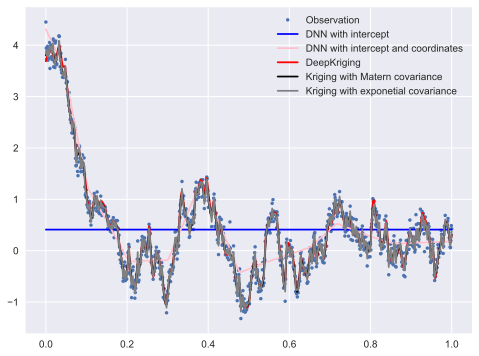

In [21]:
pylab.plot(s, y[:,0],".",label="Observation")
pylab.plot(s, y0_test_1,'blue',label="DNN with intercept")
pylab.plot(s, y0_test_2,'pink',label="DNN with intercept and coordinates")
pylab.plot(s, y0_test_3,'red',label="DeepKriging")
pylab.plot(s, y0_gpe,'black',label="Kriging with Matern covariance")
pylab.plot(s, y0_gp,'grey',label="Kriging with exponetial covariance")
pylab.legend(loc='upper right')
pylab.show()
#plt.savefig("1D_compare.pdf")

### MSE, MAE, and Nonlinearity

In [22]:
def rmse(y_true,y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return float(rmse)
def mape(y_true,y_pred):
    mape = np.mean(np.absolute(y_true-y_pred)/np.absolute(y_true))
    return float(mape)

In [24]:
rmse_combine = np.zeros((5,M))
mape_combine = np.zeros((5,M))
for i in range(M):
    print("[INFO] training %s-th replicate..." % (i+1))
    ##Kriging with exponential covariance
    m = GPy.models.GPRegression(s_train,y_train[:,i:(i+1)], kernel, noise_var = noise_var)
    mu_GP_test,var_GP_test = m.predict(s_test)
    y_gp_test = mu_GP_test
    ##Kriging with Matern covariance
    kernel2 = GPy.kern.Matern32(1,1,1)
    m2 = GPy.models.GPRegression(s_train,y_train[:,i:(i+1)],kernel2, noise_var = noise_var)
    m2.optimize()
    mu_GPE_test,var_GPE_test = m2.predict(s_test)
    y_gpe_test = mu_GPE_test
    ##DeepKriging
    model_3.fit(XRBF_train, y_train[:,i], epochs = 200, batch_size = 64, verbose = 0)
    y_dk_test = model_3.predict(XRBF[idx_test,:])
    ##DNN with intercept
    model_1.fit(X_train, y_train[:,i], epochs = 200, batch_size = 64, verbose = 0)
    y_dnn_test = model_1.predict(X[idx_test,:])
    ##DNN with intercept and coordinate
    model_2.fit(Xs_train, y_train[:,i], epochs = 200, batch_size = 64, verbose = 0)
    y_dnn2_test = model_2.predict(Xs[idx_test,:])
    ##Save the results
    rmse_combine[:,i] = np.array([rmse(y_test[:,i],y_gp_test[:,0]),\
                                  rmse(y_test[:,i],y_gpe_test[:,0]),\
                                  rmse(y_test[:,i],y_dk_test[:,0]),\
                                  rmse(y_test[:,i],y_dnn_test[:,0]),\
                                  rmse(y_test[:,i],y_dnn2_test[:,0])])
    mape_combine[:,i] = np.array([mape(y_test[:,i],y_gp_test[:,0]),\
                                  mape(y_test[:,i],y_gpe_test[:,0]),\
                                  mape(y_test[:,i],y_dk_test[:,0]),\
                                  mape(y_test[:,i],y_dnn_test[:,0]),\
                                  mape(y_test[:,i],y_dnn2_test[:,0])])
    print(rmse_combine[:,i])
    print(mape_combine[:,i])

[INFO] training 1-th replicate...
[0.17435536 0.17872447 0.18447174 1.12913684 0.32418652]
[1.04230612 0.76062314 1.41170259 4.75533475 2.81476513]
[INFO] training 2-th replicate...
[0.17014845 0.17429075 0.17408634 1.14927728 0.32402049]
[0.26952836 0.28048642 0.28498633 1.92675464 0.55446223]
[INFO] training 3-th replicate...
[0.14883158 0.15930649 0.16089365 0.78920595 0.29902235]
[0.63151202 0.59127284 0.59638014 4.17949319 1.27715838]
[INFO] training 4-th replicate...
[0.16160871 0.17113632 0.1656367  0.81536138 0.35868744]
[0.48181289 0.52698368 0.46597882 4.53807782 0.91317842]
[INFO] training 5-th replicate...
[0.17119365 0.1749914  0.18503221 0.75219033 0.2966817 ]
[0.36760754 0.36996857 0.41186677 2.32223424 0.68496227]
[INFO] training 6-th replicate...
[0.15821167 0.16693425 0.15985978 0.78149251 0.30078793]
[0.2163742  0.17715123 0.22706944 3.06827702 0.2982645 ]
[INFO] training 7-th replicate...
[0.15010289 0.15816444 0.1599082  0.72078479 0.25451951]
[0.06336804 0.0668086

In [25]:
print(np.mean(rmse_combine,axis=1))
print(np.std(rmse_combine,axis=1))
print(np.mean(mape_combine,axis=1))
print(np.std(mape_combine,axis=1))

[0.15967846 0.16602813 0.17113242 0.84494193 0.29398126]
[0.00958795 0.00897551 0.00964647 0.17663086 0.02517117]
[0.52084456 0.55560039 0.54752077 2.95465177 0.90336648]
[0.33678902 0.40703667 0.38961488 1.35410767 0.73034523]
